# Getting Started

This Notebook will go through all major steps of creating a climate scenario using `xscen`. These steps are:

- `search_data_catalogs` to find a subset of datasets that match a given project's requirements.
- `extract_dataset` to extract them.
- `regrid_dataset` to regrid all data to a common grid.
- `train` and `adjust` to bias correct the raw simulations.
- `compute_indicators` to compute a list of indicators.
- `climatological_mean` and `spatial_mean` for spatio-temporal aggregation.
- `compute_deltas` to compute deltas.
- `ensemble_stats` for ensemble statistics.
- `clean_up` for minor adjustments that have to be made in preparation for the final product.


## Initialisation

Typically, the first step should be to create a new *ProjectCatalog* to store the files that will be created during the process. More details on basic usage are provided in the Catalogs Notebook.

In [1]:
from pathlib import Path

import xscen as xs

# Folder where to put the data
output_folder = Path().absolute() / "_data"
output_folder.mkdir(exist_ok=True)

project = {
    "title": "example-gettingstarted",
    "description": "This is an example catalog for xscen's documentation.",
}

pcat = xs.ProjectCatalog(
    str(output_folder / "example-gettingstarted.json"),
    create=True,
    project=project,
    overwrite=True,
)

Successfully wrote ESM catalog json file to: file:///home/pbourg/xscen/docs/notebooks/_data/example-gettingstarted.json


### Searching a subset of datasets within *DataCatalogs*

<div class="alert alert-info"> <b>INFO</b>

At this stage, the search criteria should be for variables that will be **bias corrected**, not necessarily the variables required for the final product. For example, if `sfcWindfromdir` is the final product, then `uas` and `vas` should be searched for since these are the variables that will be bias corrected.
</div>

`xs.search_data_catalogs` is used to consult a list of *DataCatalogs* and find a subset of datasets that match given search parameters. More details on that function and possible usage are given in the [Understanding Catalogs](1_catalog.ipynb#Advanced-search:-xs.search_data_catalogs) Notebook.

The function also plays the double role of preparing certain arguments for the extraction function, as detailed in the relevant [section of this tutorial](#Simplifying-the-call-to-extract_dataset()-with-search_data_catalogs()).

Due to how different reference datasets are from climate simulations, this function might have to be called multiple times and the results concatenated into a single dictionary.

For the purpose of this tutorial, temperatures and the land fraction from NorESM2-MM will be used:

In [2]:
variables_and_freqs = {"tas": "D", "sftlf": "fx"}
other_search_criteria = {
    "source": ["NorESM2-MM"],
    "processing_level": ["raw"],
    "experiment": "ssp245",
}

cat_sim = xs.search_data_catalogs(
    data_catalogs=[str(output_folder / "tutorial-catalog.json")],
    variables_and_freqs=variables_and_freqs,
    other_search_criteria=other_search_criteria,
    periods=[2001, 2002],
    match_hist_and_fut=True,
)

cat_sim

INFO:xscen.extract:Catalog opened: <tutorial-catalog catalog with 10 dataset(s) from 10 asset(s)> from 1 files.
INFO:xscen.extract:Dispatching historical dataset to future experiments.
INFO:xscen.extract:4 assets matched the criteria : {'source': ['NorESM2-MM'], 'processing_level': ['raw'], 'experiment': 'ssp245'}.
INFO:xscen.extract:Iterating over 2 potential datasets.
/home/pbourg/xscen/xscen/extract.py:850: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/pbourg/xscen/xscen/extract.py:850: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO:xscen.extract:Found 2 with all variables requested and corresponding

{'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region': <tutorial-catalog catalog with 2 dataset(s) from 2 asset(s)>,
 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i1p1f1_example-region': <tutorial-catalog catalog with 2 dataset(s) from 2 asset(s)>}

The result of `search_data_catalog` is a dictionary with one entry per unique ID. Note that a unique ID can be associated to multiple *intake datasets*, as is the case here, because `intake-esm` groups catalog lines per *id - domain - processing_level - xrfeq*.

In [3]:
cat_sim["CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region"].df

,id,type,processing_level,bias_adjust_institution,bias_adjust_project,mip_era,activity,driving_model,institution,source,...,member,xrfreq,frequency,variable,domain,date_start,date_end,version,format,path
0,CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1...,simulation,raw,NaN,NaN,CMIP6,ScenarioMIP,NaN,NCC,NorESM2-MM,...,r1i1p1f1,D,day,"(tas,)",example-region,2001-01-01,2002-12-31,NaN,nc,/home/pbourg/xscen/docs/notebooks/_data/path_b...
1,CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1...,simulation,raw,NaN,NaN,CMIP6,ScenarioMIP,NaN,NCC,NorESM2-MM,...,r1i1p1f1,fx,fx,"(sftlf,)",example-region,NaT,NaT,NaN,nc,/home/pbourg/xscen/docs/notebooks/_data/path_b...


## Extracting data

<div class="alert alert-warning"> <b>WARNING</b>

It is heavily recommended to stop and analyse the results of `search_data_catalogs` before proceeding to the extraction function.
</div>

### Defining the region

The region for a given project is defined using a dictionary with the relevant information to be used by `clisops.core.subset`. The required fields are as follows:

region =

    "name": str,                    {this will overwrite the *domain* column in the catalog}
    "method": str,                  [gridpoint, bbox, shape, sel]
    "tile_buffer": float,    {approximate number of pixels used to expand the domain based on model resolution}
    **kwargs                        {other arguments to send `clisops`}

The argument *tile_buffer* (optional) is used to apply a buffer zone around the region that is adjusted dynamically according to model resolution during the extraction process (for *bbox* and *shape* only). This is useful to make sure that grid cells that only partially cover the region are selected too.

The documentation for the supported subsetting methods are in the following links:

- [gridpoint](https://clisops.readthedocs.io/en/latest/api.html#clisops.core.subset.subset_gridpoint)
- [bbox](https://clisops.readthedocs.io/en/latest/api.html#clisops.core.subset.subset_bbox)
- [shape](https://clisops.readthedocs.io/en/latest/api.html#clisops.core.subset.subset_shape)
- *sel* is simply a call to xarray

In [4]:
region = {
    "name": "example-region",
    "method": "bbox",
    "tile_buffer": 1.5,
    "lon_bnds": [-75, -74],
    "lat_bnds": [45, 46],
}

### Preparing arguments for *xarray*

`xscen` makes use of `intake_esm`'s [to_dataset_dict()](https://intake-esm.readthedocs.io/en/stable/reference/api.html?highlight=to_dataset_dict) for the extraction process, which will automatically compute missing variables as required. Also, this function manages Catalogs, IDs, and both NetCDF and Zarr files seamlessly. When the catalog is made of a single dataset, `to_dataset()` can be used instead to directly obtain an *xr.Dataset* instead of a dictionary.

There are a few key differences compared to using *xarray* directly, one of which being that it uses `xr.open_dataset`, even when multiple files are involved, with a subsequent call to `xr.combine_by_coords`. Kwargs are therefore separated in two:

- `xr_open_kwargs` is used for optional arguments in `xarray.open_dataset`.

- `xr_combine_kwargs` is used for optional arguments in `xarray.combine_by_coords`.

More information on possible kwargs can be obtained here: [xarray.open_dataset](https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) & [xarray.combine_by_coords](https://xarray.pydata.org/en/stable/generated/xarray.combine_by_coords.html)

In [5]:
# Kwargs for xr.open_dataset
xr_open_kwargs = {"drop_variables": ["height", "time_bnds"], "engine": "h5netcdf"}

# Kwargs for xr.combine_by_coords
xr_combine_kwargs = {"data_vars": "minimal"}

### Extraction function

Extraction is done on each dataset by calling `xs.extract_dataset()`. Since the output could have multiple frequencies, the function returns a python dictionary with keys following the output frequency.

- `catalog` is the *DataCatalog* to extract.
- `variables_and_freqs` is the same as previously used for `search_data_catalogs`.
- `periods` is used to extract specific time periods.
- `to_level` will change the *processing_level* of the output. Defaults to "extracted".
- `region`, `xr_open_kwargs`, and `xr_combine_kwargs` are described above.

**NOTE:** Calling the extraction function without passing by `search_data_catalogs` beforehand is possible, but will not support *DerivedVariables*.

<div class="alert alert-info"> <b>NOTE</b>

`extract_dataset` currently only accepts a single unique ID at a time.
</div>

In [6]:
# Example with a single simulation
ds_dict = xs.extract_dataset(
    catalog=cat_sim["CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region"],
    variables_and_freqs=variables_and_freqs,
    periods=[2001, 2002],
    region=region,
    xr_open_kwargs=xr_open_kwargs,
    xr_combine_kwargs=xr_combine_kwargs,
)

ds_dict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/home/pbourg/xscen/xscen/extract.py:211: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


{'D': <xarray.Dataset>
 Dimensions:  (time: 730, lat: 3, lon: 2)
 Coordinates:
   * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2002-12-31
   * lat      (lat) float64 45.0 46.5 48.0
   * lon      (lon) int64 -75 -74
 Data variables:
     tas      (time, lat, lon) float64 dask.array<chunksize=(730, 3, 2), meta=np.ndarray>
 Attributes: (12/22)
     comment:                 This is a test file created for the xscen tutori...
     version:                 v20191108
     intake_esm_vars:         ['tas']
     cat:id:                  CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1...
     cat:type:                simulation
     cat:processing_level:    extracted
     ...                      ...
     cat:date_start:          2001-01-01 00:00:00
     cat:date_end:            2002-12-31 00:00:00
     cat:_data_format_:       nc
     cat:path:                /home/pbourg/xscen/docs/notebooks/_data/path_bui...
     intake_esm_dataset_key:  CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r

### Saving files to disk

`extract_dataset` does not actually *save* anything to disk. It simply opens and prepares the files as per requested, using lazy computing. The result is a python dictionary containing the results, separated per *xrfreq*.

`xscen` has two functions for the purpose of saving data: `save_to_netcdf` and `save_to_zarr`. If possible for a given project, it is strongly recommended to use Zarr files since these are often orders of magnitude faster to read and create compared to NetCDF. They do have a few quirks, however:

- Chunk size must separate the dataset in *exactly* equal chunks (with the exception of the last). While it is recommended to calculate ideal chunking and provide them explicitely to the function, `io.estimate_chunks()` can be used to automatically estimate a decent chunking. In a similar way, `io.subset_maxsize()` can be used to roughly cut a dataset along the *time* dimension into subsets of a given size (in Gb), which is especially useful for saving NetCDF files.
 Chunk sizes can be passed to the two saving functions in a dictionary. Spatial dimensions can be generalized as `'X'` and `'Y'`, which will be mapped to the *xarray.Dataset*'s actual grid type's dimension names.


- Default behaviour for a Zarr is to act like a directory, with each new variable being assigned a subfolder. This is great when all required variables have the same dimensions and frequency, but will crash otherwise. If you have daily *tasmax* and subdaily *pr*, for example, they need to be assigned different paths.




#### Updating the catalog

`intake-esm` will automatically copy the catalog's entry in the dataset's metadata, with a `cat:attr` format. Where appropriate, `xscen` updates that information to keep the metadata up to date with the manipulations. `ProjectCatalog.update_from_ds` will in turn read the metadata of a Dataset and fill in the information into a new catalog entry.

This loop means that upon completing a step in the creation of a climate scenario, `ProjectCatalog.update_from_ds()` can be called to update the catalog.


In [7]:
for ds in ds_dict.values():
    filename = str(
        output_folder
        / f"{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.{ds.attrs['cat:frequency']}.zarr"
    )
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds, filename, rechunk=chunks, mode="o")

    # Strongly suggested to update the project catalog AFTER you save to disk, in case it crashes during the process
    pcat.update_from_ds(ds=ds, path=filename, info_dict={"format": "zarr"})

pcat.df

,id,type,processing_level,bias_adjust_institution,bias_adjust_project,mip_era,activity,driving_model,institution,source,...,member,xrfreq,frequency,variable,domain,date_start,date_end,version,format,path
0,CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1...,simulation,extracted,NaN,NaN,CMIP6,ScenarioMIP,NaN,NCC,NorESM2-MM,...,r1i1p1f1,D,day,"(tas,)",example-region,2001-01-01 00:00:00,2002-12-31 00:00:00,NaN,zarr,/home/pbourg/xscen/docs/notebooks/_data/CMIP6_...
1,CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1...,simulation,extracted,NaN,NaN,CMIP6,ScenarioMIP,NaN,NCC,NorESM2-MM,...,r1i1p1f1,fx,fx,"(sftlf,)",example-region,NaN,NaN,NaN,zarr,/home/pbourg/xscen/docs/notebooks/_data/CMIP6_...


### Simplifying the call to extract_dataset() with search_data_catalogs()

When a catalog was produced using `search_data_catalogs`, `xscen` will automatically save the requested periods and frequencies, in addition to *DerivedVariables*. This means that these items do not need to be included during the call to `extract_dataset` and make it possible to extract datasets that have different requirements (such as reference datasets and future simulations).

In [8]:
cat_sim[
    "CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region"
]._requested_periods

[['2001', '2002']]

In [9]:
print(
    cat_sim[
        "CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region"
    ]._requested_variables_true
)
print(
    cat_sim[
        "CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region"
    ]._requested_variable_freqs
)

['tas', 'sftlf']
['D', 'fx']


Since `cat_sim` contains multiple datasets, extracting the data should be done by looping on `.items()` or `.values()`. Also, since 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp126_r1i1p1f1_example-region' was extracted in the previous step, `pcat.exists_in_cat` can be used to skip re-extracting.

In [10]:
for key, dc in cat_sim.items():
    if not pcat.exists_in_cat(id=key, processing_level="extracted"):
        dset_dict = xs.extract_dataset(
            catalog=dc,
            region=region,
            xr_open_kwargs=xr_open_kwargs,
            xr_combine_kwargs=xr_combine_kwargs,
        )

        for ds in dset_dict.values():
            filename = str(
                output_folder
                / f"{ds.attrs['cat:id']}.{ds.attrs['cat:domain']}.{ds.attrs['cat:processing_level']}.{ds.attrs['cat:frequency']}.zarr"
            )
            chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
            xs.save_to_zarr(ds, filename, rechunk=chunks, mode="o")

            # Strongly suggested to update the project catalog AFTER you save to disk, in case it crashes during the process
            pcat.update_from_ds(ds=ds, path=filename, info_dict={"format": "zarr"})

INFO:xscen.catalog:An entry exists for: {'id': 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region', 'processing_level': 'extracted'}



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/home/pbourg/xscen/xscen/extract.py:211: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


In [11]:
# This is a hidden cell. Since the sample files are very small, we'll create fake data covering a longer time period and highjack the previously saved files.

import shutil

from xscen.testing import datablock_3d, fake_data

ds_dict = pcat.search(processing_level="extracted", variable="tas").to_dataset_dict()
for key, ds in ds_dict.items():
    attrs = ds.attrs
    filename = pcat.search(id=ds.attrs["cat:id"], variable="tas").df.path.iloc[0]

    shutil.rmtree(filename)

    data = fake_data(
        nyears=71,
        ny=len(ds.lat),
        nx=len(ds.lon),
        rand_type="tas",
        seed=sorted(list(ds_dict.keys())).index(key),
        amplitude=15,
        offset=2,
    )
    ds = datablock_3d(
        data,
        "tas",
        "lon",
        -75,
        "lat",
        45,
        x_step=1,
        y_step=1.5,
        start="1/1/1981",
        freq="D",
        as_dataset=True,
    )
    ds.attrs = attrs
    ds.attrs["cat:date_start"] = "1981-01-01"
    ds.attrs["cat:date_end"] = "2050-01-01"
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds, filename, rechunk=chunks, mode="o")

    pcat.update_from_ds(ds=ds, path=filename, info_dict={"format": "zarr"})

# For this tutorial, we'll also create a fake reference dataset
data = fake_data(
    nyears=31, ny=5, nx=4, rand_type="tas", seed=42, amplitude=25, offset=-2
)
ds_ref = datablock_3d(
    data,
    "tas",
    "lon",
    -74.875,
    "lat",
    45.275,
    x_step=0.25,
    y_step=0.55,
    start="1/1/1981",
    freq="D",
    as_dataset=True,
)
ds_ref.attrs = attrs
ds_ref.attrs["cat:date_start"] = "1981-01-01"
ds_ref.attrs["cat:date_end"] = "2010-01-01"
ds_ref.attrs["cat:source"] = "ERA5-Land"
ds_ref.attrs["cat:institution"] = "ECMWF"
ds_ref.attrs["cat:domain"] = "finer-grid"
ds_ref.attrs["cat:activity"] = None
ds_ref.attrs["cat:experiment"] = None
ds_ref.attrs["cat:member"] = None
ds_ref.attrs["cat:mip_era"] = None
ds_ref.attrs["cat:path"] = None
ds_ref.attrs["cat:id"] = xs.catalog.generate_id(ds_ref)[0]

filename = filename.replace(Path(filename).stem, ds_ref.attrs["cat:id"])
xs.save_to_zarr(ds_ref, filename, rechunk=chunks, mode="o")
pcat.update_from_ds(ds=ds_ref, path=filename, info_dict={"format": "zarr"})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


## Regridding data

<div class="alert alert-info"> <b>NOTE</b>

Regridding in `xscen` is built upon `xESMF`. For more information on basic usage and available regridding methods, [please consult their documentation](https://xesmf.readthedocs.io/en/latest/). Their [masking and extrapolation tutorial](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html) is of particular interest.

More details on the regridding functions themselves can be found within the [ESMPy](https://earthsystemmodeling.org/esmpy/) and [ESMF](https://earthsystemmodeling.org/) documentation.
</div>

The only requirement for using datasets in `xESMF` is that they contain *lon* and *lat*, with *mask* as an optional data variable. Using these, the package can manage both regular and rotated grids. The main advantage of `xESMF` compared to other tools such as *scipy*'s *griddata*, in addition to the fact that the methods are climate science-based, is that the transformation weights are calculated once and broadcasted on the *time* dimension.

### Preparing the destination grid

`xscen` currently does not explicitely support any function to create a destination grid. If required, however, `xESMF` itself has utilities that can easily create custom regular grids, such as `xesmf.util.cf_grid_2d`.

In [12]:
import xesmf

ds_grid = xesmf.util.cf_grid_2d(-75, -74, 0.25, 45, 48, 0.55)

# cf_grid_2d does not set the 'axis' attribute
ds_grid["lon"].attrs["axis"] = "X"
ds_grid["lat"].attrs["axis"] = "Y"

# xscen will use the domain to re-assign attributes, so it is important to set it up for custom grids like this
ds_grid.attrs["cat:domain"] = "finer-grid"
ds_grid

<xarray.Dataset>
Dimensions:             (lon: 4, bound: 2, lat: 5)
Coordinates:
  * lon                 (lon) float64 -74.88 -74.62 -74.38 -74.12
  * lat                 (lat) float64 45.27 45.82 46.37 46.92 47.47
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (lon, bound) float64 -75.0 -74.75 ... -74.25 -74.0
    lat_bounds          (lat, bound) float64 45.0 45.55 45.55 ... 47.2 47.75
Attributes:
    cat:domain:  finer-grid

### Masking grid cells

Masks can be used on both the original grid and the destination grid to ignore certain grid cells during the regridding process. These masks follow the `ESMF` convention, meaning that the mask is a variable within the Dataset, named *mask* and comprised of 0 and 1.

`xs.create_mask` will create an adequate DataArray, following the instructions given by *mask_args*. In the case of variables that have a time component, the first timestep will be chosen.

     mask_args:
        - 'variable'         (optional)
        - 'where_operator'   (optional)
        - 'where_threshold'  (optional)
        - 'mask_nans': bool

In [13]:
# Will mask all pixels that do not match these requirements (at least 25% land)
mask_args = {
    "variable": "sftlf",
    "where_operator": ">",
    "where_threshold": 25,
    "mask_nans": True,
}

# to_dataset() will open the dataset, as long as the search() gave a single result.
ds_example = pcat.search(
    id="CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region",
    processing_level="extracted",
    variable="sftlf",
).to_dataset()

# Masking function
ds_example["mask"] = xs.create_mask(ds_example, mask_args=mask_args)

Text(0.5, 1.0, 'mask')

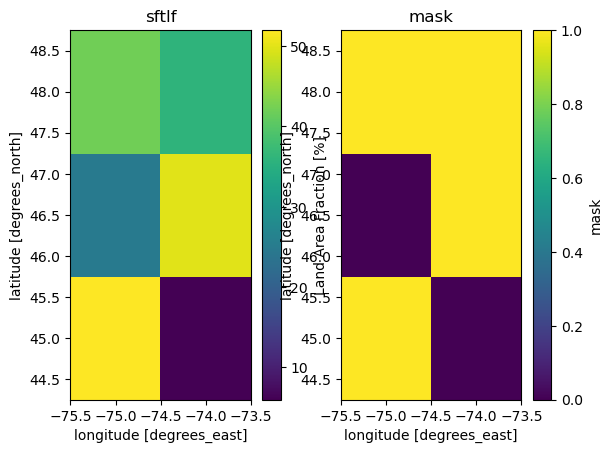

In [14]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Plot sftlf
ax = plt.subplot(121)
ds_example.sftlf.plot.imshow()
plt.title("sftlf")

# Plot the mask
plt.subplot(122)
ds_example.mask.plot.imshow()
plt.title("mask")

### Preparing arguments for xESMF.Regridder

<div class="alert alert-info">  <b>NOTE</b>

xESMF's API appears to be broken on their ReadTheDocs. For a list of available arguments and options in `Regridder()`, please consult their [Github page](https://github.com/pangeo-data/xESMF/blob/master/xesmf/frontend.py) directly.
</div>

`xESMF.Regridder` is the main utility that computes the transformation weights and performs the regridding. It is supported by many optional arguments and methods, which can be called in `xscen` through `regridder_kwargs`.

Available options are:

     method: str
         Regridding method. More details are given within the ESMF documentation and xESMF tutorials.
        - 'bilinear'  (Default)
        - 'nearest_s2d'
        - 'nearest_d2s'
        - 'conservative'
        - 'conservative_normed'
        - 'patch'

    extrap_method: str
        Extrapolation method. Defaults to None.
        - 'inverse_dist'
        - 'nearest_s2d'

    extrap_dist_exponent: float
        Exponent to raise the distance to when calculating weights for extrapolation.
        Defaults to 2.0.

    extrap_num_src_pnts : int, optional
        The number of source points to use for the extrapolation methods that use more than one source point.
        Defaults to 8

    unmapped_to_nan: boolean, optional
        Set values of unmapped points to `np.nan` instead of the ESMF default of 0.
        Defaults to True.

    periodic: boolean, optional
        Only really useful for global grids with non-conservative regridding.

Other options exist in `ESMF/ESMPy`, but not `xESMF`. As they get implemented, they should automatically get supported by `xscen`.

<div class="alert alert-info">  <b>NOTE</b>

Some utilities that exist in `xESMF` have not yet been explicitely added to `xscen`. If *conservative* regridding is desired, for instance, some additional scripts might be required on the User's side to create the lon/lat boundaries
</div>

In [15]:
regridder_kwargs = {"extrap_method": "inverse_dist"}

### Regridding function

Regridding for a Dataset is done through `xs.regrid_dataset`, which manages calls to `xESMF.Regridder` and makes sure that the output is CF-compliant.

- `weights_location` provides a path where to save the regridding weights (NetCDF file). This file (alongside `reuse_weights=True`) is used by `xESMF` to reuse the transformation weights between datasets that are deemed to have the same grid and vastly improve the speed of the function.
- `intermediate_grids` can be called to perform the regridding process in multiple steps. This is recommended when the jump in resolution is very high between the original and destination grid (e.g. from 3° to 0.08°).
- `ds_grid` & `regridder_kwargs` are described above.

In [16]:
# to_dataset_dict() is called to cast the search results as xr.Dataset objects
# frequency="^(?!fx$).*$" is used to exclude fixed fields from the results
ds_dict = pcat.search(
    processing_level="extracted", frequency="^(?!fx$).*$", domain="example-region"
).to_dataset_dict()

mask_args = {
    "variable": "sftlf",
    "where_operator": ">",
    "where_threshold": 25,
    "mask_nans": True,
}

for ds in ds_dict.values():
    # Add a mask on the original grid.
    ds["mask"] = xs.create_mask(
        pcat.search(
            id=ds.attrs["cat:id"], processing_level="extracted", variable="sftlf"
        ).to_dataset(),
        mask_args=mask_args,
    )

    # Regridding function
    ds_regrid = xs.regrid_dataset(
        ds=ds,
        weights_location=str(output_folder / "gs-weights"),
        ds_grid=ds_grid,
        regridder_kwargs=regridder_kwargs,
    )

    # Save to zarr
    filename = str(
        output_folder
        / f"{ds_regrid.attrs['cat:id']}.{ds_regrid.attrs['cat:domain']}.{ds_regrid.attrs['cat:processing_level']}.{ds_regrid.attrs['cat:frequency']}.zarr"
    )
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds=ds_regrid, filename=filename, rechunk=chunks, mode="o")
    pcat.update_from_ds(ds_regrid, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


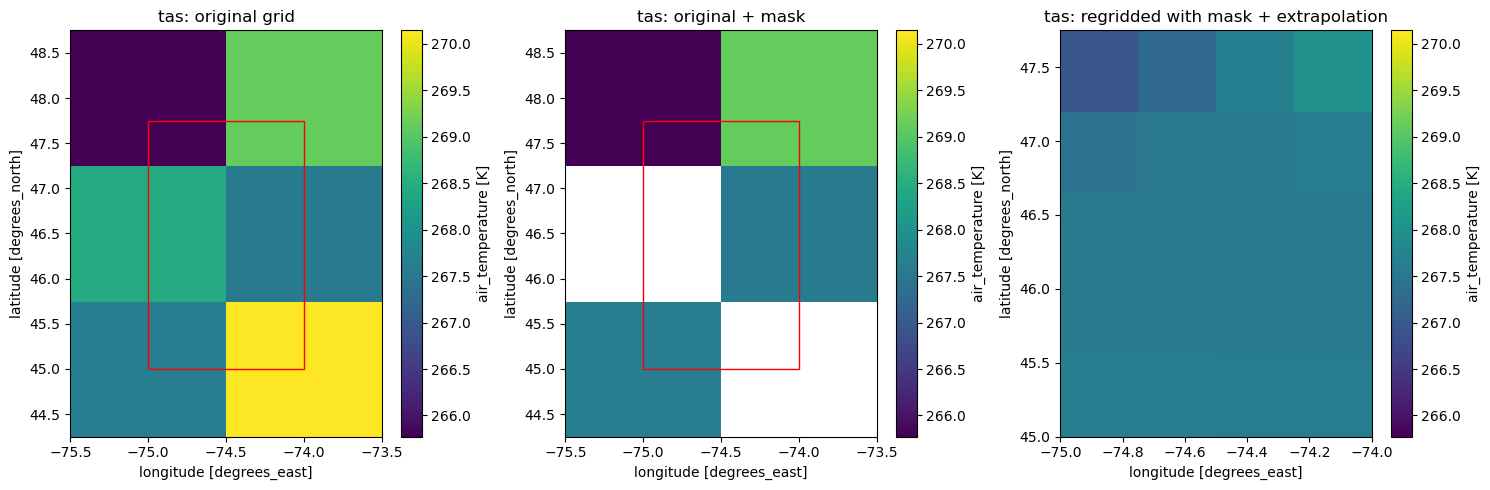

In [17]:
import matplotlib.patches as patches

plt.figure(figsize=[15, 5])

vmin = float(ds.tas.isel(time=0).min())
vmax = float(ds.tas.isel(time=0).max())

ax = plt.subplot(131)
ds.tas.isel(time=0).plot.imshow(vmin=vmin, vmax=vmax)
plt.title("tas: original grid")
rect = patches.Rectangle(
    (-75, 45), 1, 2.75, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)

ax = plt.subplot(132)
(ds.tas.isel(time=0).where(ds.mask == 1)).plot.imshow(vmin=vmin, vmax=vmax)
rect = patches.Rectangle(
    (-75, 45), 1, 2.75, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)
plt.title("tas: original + mask")
plt.tight_layout()

plt.subplot(133)
ds_regrid.tas.isel(time=0).plot.imshow(vmin=vmin, vmax=vmax)
plt.title("tas: regridded with mask + extrapolation")
plt.tight_layout()

## Bias adjusting data

<div class="alert alert-info"> <b>NOTE</b>

Bias adjustment in `xscen` is built upon `xclim.sdba`. For more information on basic usage and available methods, [please consult their documentation](https://xclim.readthedocs.io/en/stable/sdba.html).
</div>

### Preparing arguments for xclim.sdba

Many optional arguments are used by `xclim.sdba` during the training and adjustment processes. These options heavily depend on the bias adjustment method used, so it is recommended to consult their documentation before proceeeding further.

These arguments can be sent by using `xclim_train_kwargs` and `xclim_adjust_kwargs` during the call to `xs.train` and `xs.adjust` respectively.

In [18]:
xclim_train_args = {"kind": "+", "nquantiles": 50}

xclim_adjust_args = {"detrend": 3, "interp": "linear", "extrapolation": "constant"}

### Bias adjustment function

Bias adjustment is done through `xs.train` and `xs.adjust`. They are kept separate to account for cases where a voluminous dataset would require saving after the training step.

The arguments to *train()* are:

- `dref` and `dhist` indicate the reference and historical datasets.
- `var` indicates which variable to bias correct.
- `period` defines the period used for building the transfer function.
- `method` indicates which bias adjusting method to call within `xclim.sdba`.
- `maximal_calendar` instructs on which calendar to use, following this hierarchy: 360_day < noleap < standard < all_leap
- `adapt_freq` is used for bias adjusting the frequency of dry/wet days (precipitation only).
- `jitter_under` adds a random noise under a given threshold.
- `jitter_over`adds a random noise over a given threshold.
- `xclim_train_kwargs` is described above.

The arguments to *adjust()* are:

- `dtrain` is the result of `biasadjust.train`.
- `dsim` is the simulation to bias adjust.
- `periods` defines the period(s) to bias adjust.
- `xclim_adjust_kwargs` is described above.

<div class="alert alert-info">  <b>NOTE</b>

These functions currently do not support multiple variables due to the fact that train and adjust arguments might vary. The function must be called separately for every variable.
</div>

In [19]:
ds_dict = pcat.search(processing_level="regridded").to_dataset_dict()

# # Open the reference dataset, in this case ERA5-Land
ds_ref = pcat.search(processing_level="extracted", source="ERA5-Land").to_dataset()

# Currently, only a single variable can be bias adjusted at a time
variables = ["tas"]
for v in variables:
    for ds in ds_dict.values():
        # Train
        ds_train = xs.train(
            dref=ds_ref,
            dhist=ds,
            var=["tas"],
            period=["1981", "2010"],
            xclim_train_args=xclim_train_args,
        )

        # Adjust
        ds_adj = xs.adjust(
            dtrain=ds_train,
            dsim=ds,
            periods=["1981", "2050"],
            bias_adjust_institution="Ouranos",  # add new attribute cat:bias_adjust_institution
            bias_adjust_project="xscen-tutorial",  # add new attribute cat:bias_adjust_project
            xclim_adjust_args=xclim_adjust_args,
        )

        # Save to zarr
        filename = str(
            output_folder
            / f"{ds_adj.attrs['cat:id']}.{ds_adj.attrs['cat:domain']}.{ds_adj.attrs['cat:processing_level']}.{ds_adj.attrs['cat:frequency']}.zarr"
        )
        chunks = xs.io.estimate_chunks(ds_adj, dims=["time"], target_mb=50)
        xs.save_to_zarr(ds=ds_adj, filename=filename, rechunk=chunks, mode="o")
        pcat.update_from_ds(ds_adj, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


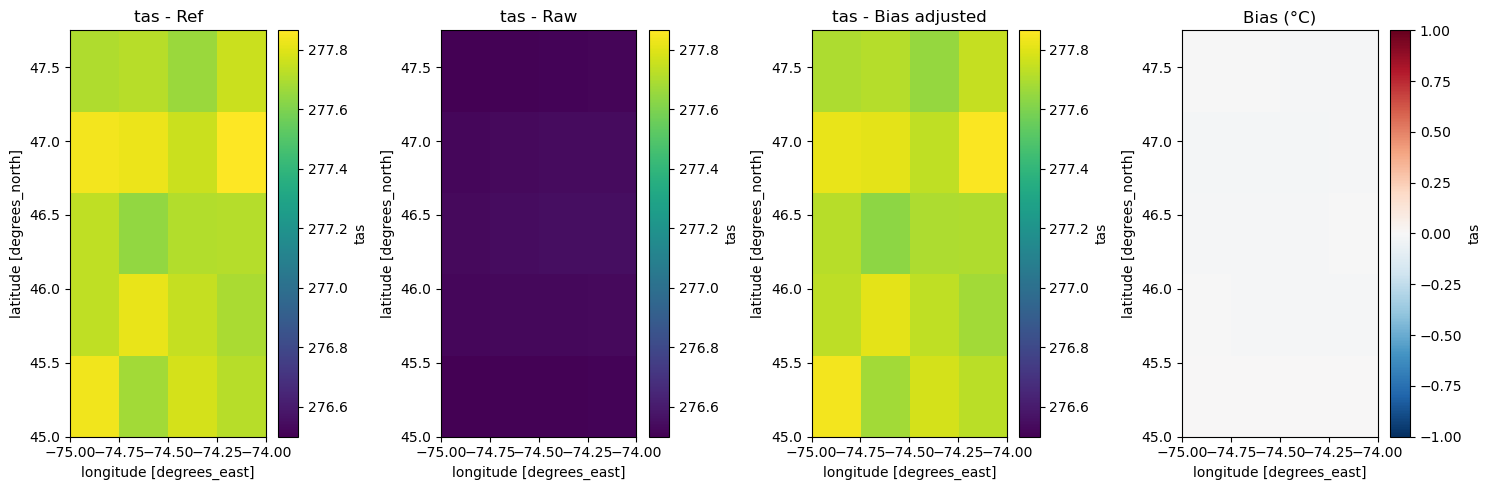

In [20]:
ds = pcat.search(
    processing_level="regridded",
    variable="tas",
    id="CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region",
).to_dataset()
ds_adj = pcat.search(
    processing_level="biasadjusted",
    variable="tas",
    id="CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i1p1f1_example-region",
).to_dataset()

vmin = min(
    [
        float(ds_ref.tas.sel(time=slice("1981", "2010")).mean(dim="time").min()),
        float(ds.tas.sel(time=slice("1981", "2010")).mean(dim="time").min()),
    ]
)
vmax = max(
    [
        float(ds_ref.tas.sel(time=slice("1981", "2010")).mean(dim="time").max()),
        float(ds.tas.sel(time=slice("1981", "2010")).mean(dim="time").max()),
    ]
)

fig = plt.figure(figsize=(15, 5))
plt.subplot(141)
ds_ref.tas.sel(time=slice("1981", "2010")).mean(dim="time").transpose(
    "lat", ...
).plot.imshow(vmin=vmin, vmax=vmax)
plt.title("tas - Ref")

plt.subplot(142)
ds.tas.sel(time=slice("1981", "2010")).mean(dim="time").transpose(
    "lat", ...
).plot.imshow(vmin=vmin, vmax=vmax)
plt.title("tas - Raw")

plt.subplot(143)
ds_adj.tas.sel(time=slice("1981", "2010")).mean(dim="time").transpose(
    "lat", ...
).plot.imshow(vmin=vmin, vmax=vmax)
plt.title("tas - Bias adjusted")
plt.tight_layout()

plt.subplot(144)
(
    ds_adj.tas.sel(time=slice("1981", "2010")).mean(dim="time")
    - ds_ref.tas.sel(time=slice("1981", "2010")).mean(dim="time")
).transpose("lat", ...).plot.imshow(vmin=-1, vmax=1, cmap="RdBu_r")
plt.title("Bias (°C)")
plt.tight_layout()

## Computing indicators

<div class="alert alert-info"> <b>NOTE</b>

`xscen` relies heavily on `xclim`'s YAML support for calculating indicators. For more information on how to build the YAML file, consult [this Notebook](https://xclim.readthedocs.io/en/latest/notebooks/extendxclim.html?highlight=yaml#YAML-file).
</div>

`xs.compute_indicators` makes use of *xclim*'s indicator modules functionalities to compute a given list of indicators. It is called by either using:

- The path to a [YAML file](https://xclim.readthedocs.io/en/stable/api.html#yaml-file-structure) structured in a way compatible with *xclim*'s `build_indicator_module_from_yaml`
- An indicator module directly
- A sequence of indicators
- A sequence of tuples as returned by calling `iter_indicators()` on an indicator module.

Same as the extraction function, since the output could have multiple frequencies, the function returns a python dictionary with the output frequency as keys. The inputs of `xs.compute_indicators` are:

- `ds` is the *xr.Dataset* containing the required variables.
- `indicators` instructs on which indicator(s) to compute. It can be a number of things, as listed above.
- `periods` is a list of [start, end] of continuous periods to be considered.

This example will use a simple YAML file structured like this:

```
realm: atmos
indicators:
  growing_degree_days:
    base: growing_degree_days
  tg_min:
    base: tg_min
```


In [21]:
ds_dict = pcat.search(processing_level="biasadjusted").to_dataset_dict()

for ds in ds_dict.values():
    # Output is dict, but it has only one frequency.
    _, ds_ind = xs.compute_indicators(
        ds=ds,
        indicators=Path().absolute() / "samples" / "indicators.yml",
    ).popitem()

    # Save the results
    filename = str(
        output_folder
        / f"{ds_ind.attrs['cat:id']}.{ds_ind.attrs['cat:domain']}.{ds_ind.attrs['cat:processing_level']}.{ds_ind.attrs['cat:frequency']}.zarr"
    )
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds_ind, filename, rechunk=chunks, mode="o")

    # Strongly suggested to update the project catalog AFTER you save to disk, in case it crashes during the process
    pcat.update_from_ds(ds=ds_ind, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.indicators:1 - Computing growing_degree_days.
INFO:xscen.indicators:2 - Computing tg_min.
INFO:xscen.indicators:1 - Computing growing_degree_days.
INFO:xscen.indicators:2 - Computing tg_min.


In [22]:
display(ds_ind)

<xarray.Dataset>
Dimensions:              (lat: 5, lon: 4, time: 70)
Coordinates:
  * lat                  (lat) float64 45.27 45.82 46.37 46.92 47.47
  * lon                  (lon) float64 -74.88 -74.62 -74.38 -74.12
  * time                 (time) object 1981-01-01 00:00:00 ... 2050-01-01 00:...
Data variables:
    growing_degree_days  (time, lon, lat) float64 dask.array<chunksize=(70, 4, 5), meta=np.ndarray>
    tg_min               (time, lon, lat) float64 dask.array<chunksize=(70, 4, 5), meta=np.ndarray>
Attributes: (12/25)
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    cat:bias_adjust_project:      xscen-tutorial
    cat:date_end:                 2050-12-31 00:00:00
    cat:date_start:               1981-01-01 00:00:00
    ...                           ...
    comment:                      This is a test file created for the xscen t...
    history:                      [2023-10-09 15:41:03] regridded with argume...
    intake_esm_dataset_key:       CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i...
    intake_esm_vars:              ('tas',)
    regrid_method:                bilinear
    version:                      v20191108

## Spatio-temporal aggregation

### Climatological mean

`xs.climatological_mean` is used to compute a *n*-year average over `ds.time.dt.year`.

**NOTE:** The aggregation is over *year*, __*not* over *time*__. For example, if given monthly data, the climatological average will be computed separately for January, February, etc. This means that the data should already be aggregated at the required frequency, for example using `xs.compute_indicators` to compute yearly, seasonal, or monthly indicators.

The optional arguments are as follow:

- `window` indicates how many year to use for the average. Uses all available years by default.
- `min_period` minimum number of years required for a value to be computed durring the `rolling` operation.
- `interval` indicates the interval (in years) at which to provide an output.
- `periods` is a list of [start, end] of continuous periods to be considered.

In [23]:
ds_dict = pcat.search(processing_level="indicators").to_dataset_dict()

for key, ds in ds_dict.items():
    ds_mean = xs.climatological_mean(
        ds=ds, window=30, interval=10, to_level="30yr-climatology"
    )

    # Save to zarr
    filename = str(
        output_folder
        / f"{ds_mean.attrs['cat:id']}.{ds_mean.attrs['cat:domain']}.{ds_mean.attrs['cat:processing_level']}.{ds_mean.attrs['cat:frequency']}.zarr"
    )
    xs.save_to_zarr(ds=ds_mean, filename=filename, mode="o")
    pcat.update_from_ds(ds_mean, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


In [24]:
display(ds_mean)

<xarray.Dataset>
Dimensions:              (lat: 5, lon: 4, time: 5)
Coordinates:
  * lat                  (lat) float64 45.27 45.82 46.37 46.92 47.47
  * lon                  (lon) float64 -74.88 -74.62 -74.38 -74.12
    horizon              (time) <U9 '1981-2010' '1991-2020' ... '2021-2050'
  * time                 (time) object 1981-01-01 00:00:00 ... 2021-01-01 00:...
Data variables:
    growing_degree_days  (time, lon, lat) float64 dask.array<chunksize=(5, 4, 5), meta=np.ndarray>
    tg_min               (time, lon, lat) float64 dask.array<chunksize=(5, 4, 5), meta=np.ndarray>
Attributes: (12/25)
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    cat:bias_adjust_project:      xscen-tutorial
    cat:date_end:                 2050-01-01 00:00:00
    cat:date_start:               1981-01-01 00:00:00
    ...                           ...
    comment:                      This is a test file created for the xscen t...
    history:                      [2023-10-09 15:41:02] regridded with argume...
    intake_esm_dataset_key:       CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i...
    intake_esm_vars:              ('growing_degree_days', 'tg_min')
    regrid_method:                bilinear
    version:                      v20191108

#### Horizon coordinate and time dimension

Even if no `interval` is called, `xs.climatological_mean` will substantially change the nature of the `time` dimension, because it now represents an aggregation over time. While no standards exist on how to reflect that in a dataset, the following was chosen for `xscen`:

- `time` corresponds to the first timestep of each temporal average.
- `horizon` is a new coordinate that either follows the format YYYY-YYYY or a warming-level specific nomenclature.
- The `cat:frequency` and `cat:xrfreq` attributes remain unchanged.

In [25]:
print(f"time: {ds_mean.time.values}")
print(f"horizon: {ds_mean.horizon.values}")
print(f"cat:xrfreq attribute: {ds_mean.attrs['cat:xrfreq']}")

time: [cftime.DatetimeNoLeap(1981, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1991, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2001, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2011, 1, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2021, 1, 1, 0, 0, 0, 0, has_year_zero=True)]
horizon: ['1981-2010' '1991-2020' '2001-2030' '2011-2040' '2021-2050']
cat:xrfreq attribute: AS-JAN


### Computing deltas

`xs.compute_deltas` is pretty self-explanatory. However, note that this function relies on the `horizon` coordinate described above and, thus, is intended to be performed following some kind of temporal aggregation.

It has the following arguments:

- `reference_horizon` indicates which horizon to use as reference.
- `kind` is either "+", "/", or "%" for absolute, relative, or percentage deltas respectively. This argument can also be a dictionary, with the keys corresponding to data variables.

In [26]:
ds_dict = pcat.search(processing_level="30yr-climatology").to_dataset_dict()

for key, ds in ds_dict.items():
    ds_delta = xs.compute_deltas(
        ds=ds,
        reference_horizon="1981-2010",
        kind={"growing_degree_days": "%", "tg_min": "+"},
        to_level="deltas",
    )

    # Save to zarr
    filename = str(
        output_folder
        / f"{ds_delta.attrs['cat:id']}.{ds_delta.attrs['cat:domain']}.{ds_delta.attrs['cat:processing_level']}.{ds_delta.attrs['cat:frequency']}.zarr"
    )
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds=ds_delta, filename=filename, rechunk=chunks, mode="o")
    pcat.update_from_ds(ds_delta, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


In [27]:
print(f"Deltas over {ds_delta.horizon.values}")
display(ds_delta.tg_min_delta_1981_2010.isel(lon=0, lat=0).values)

Deltas over ['1981-2010' '1991-2020' '2001-2030' '2011-2040' '2021-2050']


array([0.        , 0.04401971, 0.46335546, 1.33483675, 2.48586193])

### Spatial mean

`xs.spatial_mean` is used to compute the spatial average over a given region, using various methods. The argument `call_clisops` can also be used to subset the domain prior to the averaging.

- `method: cos-lat` will perform an average operation over the spatial dimensions, accounting for changes in grid cell area along the 'lat' coordinate.


- `method: interp_centroid` will perform an interpolation towards given coordinates or towards the centroid of a region.
   - `kwargs` is used to sent arguments to `.interp()`, including `lon` and `lat`.
   - `region` can alternatively be used to send a gridpoint, bbox, or shapefile and compute the centroid. This argument is a dictionary that follows the same requirements as the one for `xs.extract` described previously.


- `method: xesmf` will perform a call to *xESMF*'s [SpatialAverager](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Spatial_Averaging.html). This method is the most precise, especially for irregular regions, but can be much slower.
   - `kwargs` is used to sent arguments to `xesmf.SpatialAverager`.
   - `region` is used to send a bbox or shapefile to the `SpatialAverager`. This argument is a dictionary that follows the same requirements as the one for `xs.extract` described previously.
   - `simplify_tolerance` is a float that can be used to change the precision (in degree) of a shapefile before sending it to `SpatialAverager`.

In [28]:
ds_dict = pcat.search(processing_level="deltas", domain="finer-grid").to_dataset_dict()

for key, ds in ds_dict.items():
    ds_savg = xs.spatial_mean(
        ds=ds,
        method="interp_centroid",
        kwargs={"method": "linear", "lon": -74.5, "lat": 47},
        to_domain="aggregated",
    )

    # Save to zarr
    filename = str(
        output_folder
        / f"{ds_savg.attrs['cat:id']}.{ds_savg.attrs['cat:domain']}.{ds_savg.attrs['cat:processing_level']}.{ds_savg.attrs['cat:frequency']}.zarr"
    )
    chunks = xs.io.estimate_chunks(ds, dims=["time"], target_mb=50)
    xs.save_to_zarr(ds=ds_savg, filename=filename, rechunk=chunks, mode="o")
    pcat.update_from_ds(ds_savg, path=filename, format="zarr")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


In [29]:
# Aggregated deltas over the study area
display(ds_savg)

<xarray.Dataset>
Dimensions:                              (time: 5)
Coordinates:
    horizon                              (time) <U9 dask.array<chunksize=(5,), meta=np.ndarray>
  * time                                 (time) object 1981-01-01 00:00:00 .....
    lon                                  float64 -74.5
    lat                                  int64 47
Data variables:
    growing_degree_days_delta_1981_2010  (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    tg_min_delta_1981_2010               (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
Attributes: (12/25)
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    cat:bias_adjust_project:      xscen-tutorial
    cat:date_end:                 2021-01-01 00:00:00
    cat:date_start:               1981-01-01 00:00:00
    ...                           ...
    comment:                      This is a test file created for the xscen t...
    history:                      [2023-10-09 15:42:16] xarray.interp(**{'met...
    intake_esm_dataset_key:       CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r2i...
    intake_esm_vars:              ('tg_min_delta_1981_2010', 'growing_degree_...
    regrid_method:                bilinear
    version:                      v20191108

## Ensemble statistics

### Weights

Typically, if an ensemble is inhomogeneous (uneven number of realizations per model, mix of GCMs and RCMs, etc.), the first step should be to call `xs.generate_weights` to create an adequate guess of what the weights should be between the various datasets. Do note, however, that this function does not replace an explicit assessment of the performance or independence of the simulations, and the results provided should be taken with a grain of salt.

The arguments are as follows:

- `independence_level` instruct on which weighting scheme to use and strongly influences the outputs. One of 'model', 'GCM', 'institution'.
- `experiment_weights` can be used to assign a given total weight to each experiment (currently only supports giving 1 to each experiment).
- `skipna` instructs on whether the weights should account for simulations with missing data.
- `v_for_skipna` is the variable to use in the case of `skipna=False`.
- `standardize` to make the weights sum to 1 for each instance of 'horizon' or 'time'.

<div class="alert alert-info"> <b>NOTE</b>

`generate_weights` was built with `xscen` in mind, and thus relies on the `cat:` attributes automatically generated by `intake-esm` when data is loaded from a catalog. In the case of data generated elsewhere, the required and recommended attributes should minimally be added to the dataset before using this function.
</div>

In [30]:
# We don't have many simulations in this example to perform ensemble statistics, but we'll use the two SSP2-4.5 realizations
datasets = pcat.search(
    processing_level="deltas", domain="aggregated", experiment="ssp245"
).to_dataset_dict()

weights = xs.generate_weights(datasets, independence_level="model")
display(weights)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


<xarray.DataArray (realization: 2)>
array([0.5, 0.5])
Coordinates:
  * realization  (realization) <U88 'CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_...

### Ensemble stats

`xs.ensemble_stats` creates an ensemble out of many datasets and computes statistics on that ensemble (min, max, mean, percentiles, etc.) using the `xclim.ensembles` module. The inputs can be given in the form of a list or a dictionary of xr.Dataset or of paths.

The arguments are as follows:

- `statistics` is a dictionary that instructs on which `xclim.ensembles` statistics to call. It follows the format {function: arguments}.
- `weights` is used to weight the various datasets, if needed.
- `common_attrs_only`: `xclim.ensembles.create_ensemble` copies the attributes from the first dataset, but this might not be representative of the new ensemble. If `common_attrs_only` is True, it only keeps the global attributes that are the same for all datasets and generates a new ID.
- `create_kwargs`: If given a set of paths, `xclim.ensembles.create_ensemble` will ignore the chunking on disk and open the datasets with only a chunking along the new `realization` dimension. Thus, for large datasets, this should be used to explicitely specify chunks.

In [31]:
ens_stats = xs.ensemble_stats(
    datasets=datasets,
    statistics={
        "ensemble_percentiles": {"split": False}
    },  # should be an existing function in xclim.ensembles
    weights=weights,
    common_attrs_only=True,
)

path = output_folder / f"ensemble_{ens_stats.attrs['cat:id']}.zarr"
xs.save_to_zarr(ens_stats, filename=path, mode="o")
pcat.update_from_ds(ds=ens_stats, path=path, format="zarr")

INFO:xscen.ensembles:Creating ensemble with 2 simulations and calculating ensemble_percentiles.


In [32]:
display(ens_stats)

<xarray.Dataset>
Dimensions:                              (time: 5, percentiles: 3)
Coordinates:
    horizon                              (time) <U9 dask.array<chunksize=(5,), meta=np.ndarray>
    lat                                  int64 47
    lon                                  float64 -74.5
  * time                                 (time) object 1981-01-01 00:00:00 .....
  * percentiles                          (percentiles) int64 10 50 90
Data variables:
    growing_degree_days_delta_1981_2010  (percentiles, time) float64 dask.array<chunksize=(3, 5), meta=np.ndarray>
    tg_min_delta_1981_2010               (percentiles, time) float64 dask.array<chunksize=(3, 5), meta=np.ndarray>
Attributes: (12/20)
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    cat:bias_adjust_project:      xscen-tutorial
    cat:domain:                   aggregated
    cat:experiment:               ssp245
    ...                           ...
    comment:                      This is a test file created for the xscen t...
    intake_esm_vars:              ('tg_min_delta_1981_2010', 'growing_degree_...
    regrid_method:                bilinear
    version:                      v20191108
    cat:id:                       xscen-tutorial_CMIP6_ScenarioMIP_NCC_NorESM...
    ensemble_size:                2

## Clean up

At any time, such as after bias adjustment, `xs.clean_up` can be called to perform a number of small modifications to the datasets. That function can:

 - convert the variables to non-CF units using `xs.utils.change_units`
 - call the `xs.utils.maybe_unstack` function
 - convert the calendar and interpolate over missing dates
 - remove, remove everything but, and/or add a list of attributes
 - change the prefix of the catalog attrs (by default: `cat:`)

in that order.


### Calendars

During the bias adjustment step, it is frequent to convert the calendar to 'noleap'. However, once that step has been processed, we might want to put back all the February 29th (or other missing data in the case of '360_day' calendar). This can be done using the `convert_calendar_kwargs` argument of `xs.clean_up`, which passes a dictionary to `xclim.core.calendar.convert_calendar`.

Usually, we want to linearly interpolate the missing temperatures, but put 0 mm/day for missing precipitation. If our dataset has many variables, the `missing` argument (for `convert_calendar`) can be set for each variable with `missing_by_var`. If `missing_by_var` is given 'interpolate', the missing data will be filled with NaNs, then linearly interpolated over time.

Eg. `{'tasmax':'interpolate', 'pr':[0]}`


In [33]:
convert_calendar_kwargs = {"target": "standard"}
missing_by_var = {"tas": "interpolate"}

### Attributes

We might want to add, remove or modify the attributes.

It is possible to write a list of attributes to remove with `attrs_to_remove`, or a list of attributes to keep and remove everything else with `remove_all_attrs_except`. Both take the shape of a dictionnary where the keys are the variables (and 'global' for global attrs) and the values are the list.

The element of the list can be exact matches for the attribute names or use the same regex matching rules as `intake_esm`:

- ending with a '*' means checks if the substring is contained in the string
- starting with a '^' means check if the string starts with the substring.

Attributes can also be added to datasets using `add_attrs`. This is a dictionary where the keys are the variables and the values are a another dictionary of attributes.

It is also possible to modify the catalogue prefix 'cat:' by a new string with `change_attr_prefix`. Don't use this if this is not the last step of your workflow.


In [34]:
attrs_to_remove = {
    "tas": ["name*"]
}  # remove tas attrs that contain the substring 'name'
remove_all_attrs_except = {
    "global": ["^cat:"]
}  # remove all the global attrs EXCEPT for the one starting with cat:
add_attrs = {
    "tas": {"notes": "some crucial information"}
}  # add a new tas attribute named 'notes' with value 'some crucial information'
change_attr_prefix = "dataset:"  # change /cat to dataset:

In [35]:
ds = pcat.search(
    processing_level="biasadjusted", variable="tas", experiment="ssp245", member="r1.*"
).to_dataset()

ds_clean = xs.clean_up(
    ds=ds,
    variables_and_units={"tas": "degC"},  # convert units
    convert_calendar_kwargs=convert_calendar_kwargs,
    missing_by_var=missing_by_var,
    attrs_to_remove=attrs_to_remove,
    remove_all_attrs_except=remove_all_attrs_except,
    add_attrs=add_attrs,
    change_attr_prefix=change_attr_prefix,
)

INFO:xscen.utils:Converting units: {'tas': 'degC'}
INFO:xscen.utils:Converting calendar with {'target': 'standard', 'missing': -9999} 
INFO:root:Filling missing tas with interpolate


In [36]:
from xclim.core.calendar import get_calendar

# Inspect calendars and the interpolated values
print("Initial calendar: ", get_calendar(ds.time))
print(ds.time.sel(time=slice("2000-02-28", "2000-03-01")).values)
print(ds.tas.sel(time=slice("2000-02-28", "2000-03-01")).isel(lat=1, lon=1).values)

print("Final calendar: ", get_calendar(ds_clean.time))
print(ds_clean.time.sel(time=slice("2000-02-28", "2000-03-01")).values)
print(
    ds_clean.tas.sel(time=slice("2000-02-28", "2000-03-01")).isel(lat=1, lon=1).values
)
print("")
print("Inspect initial attributes")
display(ds)

print("")
print("Inspect final attributes")
display(ds_clean)

Initial calendar:  noleap
[cftime.DatetimeNoLeap(2000, 2, 28, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(2000, 3, 1, 0, 0, 0, 0, has_year_zero=True)]
[10.1320762   8.56638259]
Final calendar:  standard
[cftime.DatetimeGregorian(2000, 2, 28, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2000, 2, 29, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2000, 3, 1, 0, 0, 0, 0, has_year_zero=False)]
[10.1320762   9.34922939  8.56638259]

Inspect initial attributes


<xarray.Dataset>
Dimensions:  (time: 25550, lon: 4, lat: 5)
Coordinates:
  * lat      (lat) float64 45.27 45.82 46.37 46.92 47.47
  * lon      (lon) float64 -74.88 -74.62 -74.38 -74.12
  * time     (time) object 1981-01-01 00:00:00 ... 2050-12-31 00:00:00
Data variables:
    tas      (time, lon, lat) float64 dask.array<chunksize=(25550, 4, 5), meta=np.ndarray>
Attributes: (12/25)
    cat:_data_format_:            zarr
    cat:activity:                 ScenarioMIP
    cat:bias_adjust_institution:  Ouranos
    cat:bias_adjust_project:      xscen-tutorial
    cat:date_end:                 2050-12-31 00:00:00
    cat:date_start:               1981-01-01 00:00:00
    ...                           ...
    comment:                      This is a test file created for the xscen t...
    history:                      [2023-10-09 15:41:03] regridded with argume...
    intake_esm_dataset_key:       CMIP6_ScenarioMIP_NCC_NorESM2-MM_ssp245_r1i...
    intake_esm_vars:              ['tas']
    regrid_method:                bilinear
    version:                      v20191108


Inspect final attributes


<xarray.Dataset>
Dimensions:  (time: 25567, lon: 4, lat: 5)
Coordinates:
  * lat      (lat) float64 45.27 45.82 46.37 46.92 47.47
  * lon      (lon) float64 -74.88 -74.62 -74.38 -74.12
  * time     (time) object 1981-01-01 00:00:00 ... 2050-12-31 00:00:00
Data variables:
    tas      (time, lon, lat) float64 dask.array<chunksize=(25567, 4, 5), meta=np.ndarray>
Attributes: (12/19)
    dataset:_data_format_:            zarr
    dataset:activity:                 ScenarioMIP
    dataset:bias_adjust_institution:  Ouranos
    dataset:bias_adjust_project:      xscen-tutorial
    dataset:date_end:                 2050-12-31 00:00:00
    dataset:date_start:               1981-01-01 00:00:00
    ...                               ...
    dataset:path:                     /home/pbourg/xscen/docs/notebooks/_data...
    dataset:processing_level:         biasadjusted
    dataset:source:                   NorESM2-MM
    dataset:type:                     simulation
    dataset:variable:                 tas
    dataset:xrfreq:                   D